In [1]:
import pandas as pd
import numpy as np

# Load and Preprocess Data

In [13]:
# Load Perfomrance Data
performance_data = pd.read_csv("../Data/models_performance_on_tasks.csv")
# Drop useless columns
performance_data.drop([c for c in performance_data.columns if "Unnamed" in c], inplace=True, axis=1)
performance_data.head()

,model,dt_ImageNet,dt_Aircraft,dt_Caltech101,dt_Cars,dt_CIFAR10,dt_CIFAR100,dt_DTD,dt_Flowers,dt_Food,...,CropDiseases_20_shot,CropDiseases_50_shot,EuroSAT_5_shot,EuroSAT_20_shot,EuroSAT_50_shot,sne_Mean,sne_Median,sne_11.25,sne_22.5,sne_30
0,InsDis(R),59.5,36.88,71.55,30.49,80.57,59.87,68.24,83.17,63.45,...,91.95,92.70,81.29,86.52,88.25,32.99,27.35,23.58,43.02,53.51
1,MoCoV1(R),60.6,36.19,75.37,31.29,80.21,57.70,68.67,82.04,61.50,...,92.04,92.87,81.32,86.55,87.72,33.69,28.63,21.51,41.07,51.87
2,PCLV1(R),61.5,22.93,77.74,12.51,82.03,55.88,62.82,64.95,47.85,...,80.74,82.83,66.56,75.19,76.41,37.90,33.58,16.73,34.96,45.43
3,PIRL(R),61.7,37.67,74.37,30.48,82.65,61.25,68.88,84.74,64.64,...,91.19,92.18,82.14,87.06,88.55,33.16,27.66,22.24,42.41,53.12
4,PCLV2(R),67.6,36.78,86.21,30.83,91.93,73.58,70.64,85.21,64.84,...,92.58,93.57,81.10,87.94,89.23,33.98,28.67,21.95,41.21,51.76


In [2]:
# Load Dissect Profile Data
raw_data = pd.read_csv("../Data/models_dissect_profiles.csv")
# Remove results with "-" label as they correspond to background (pixles with no class)
raw_data = raw_data[raw_data["label"] != "-"]
# Remove untis with class matching less than 0.04 iou (as par Dissect authors)
raw_data = raw_data[raw_data["iou"]>0.04]

In [82]:
# Normalize Profile Values

# unique concepts
#66 object
u_objects, objects_counts = np.unique(raw_data[raw_data["category"]=="object"]["label"], return_counts=True)
#52 part
u_parts, parts_counts = np.unique(raw_data[raw_data["category"]=="part"]["label"], return_counts=True)
#15 material
u_materials, materials_counts = np.unique(raw_data[raw_data["category"]=="material"]["label"], return_counts=True)
#8 color
u_colors, colors_counts = np.unique(raw_data[raw_data["category"]=="color"]["label"], return_counts=True)

# Count number of unites matched to each concept
aggregation = raw_data.groupby(["name","label", "category"], as_index=False).agg({"iou": ["count"]})
aggregation.columns = ["name", "label", "category", "count"]

# Rename labeks based on category
aggregation.loc[ aggregation["category"]=="object" , "label"] = "o_" + aggregation.loc[ aggregation["category"]=="object" , "label"] 
aggregation.loc[ aggregation["category"]=="part" , "label"] = "p_" + aggregation.loc[ aggregation["category"]=="part" , "label"] 
aggregation.loc[ aggregation["category"]=="material" , "label"] = "m_" + aggregation.loc[ aggregation["category"]=="material" , "label"] 
aggregation.loc[ aggregation["category"]=="color" , "label"] = "c_" + aggregation.loc[ aggregation["category"]=="color" , "label"] 

# Normalize counts by the total number of found matches for each category
aggregation["count"]  = aggregation["count"] / (aggregation["category"]=="object").map(lambda x: len(u_objects) if x else 1)
aggregation["count"]  = aggregation["count"] / (aggregation["category"]=="material").map(lambda x: len(u_materials) if x else 1)
aggregation["count"]  = aggregation["count"] / (aggregation["category"]=="part").map(lambda x: len(u_parts) if x else 1)
aggregation["count"]  = aggregation["count"] / (aggregation["category"]=="color").map(lambda x: len(u_colors) if x else 1)

# Reshape data as a vector of found concepts for each model
aggregation = aggregation.pivot(index='name', columns='label')["count"]
dissect_profiles = pd.DataFrame(aggregation.values, columns = aggregation.keys().tolist(), index=aggregation.index)
dissect_profiles.reset_index()
dissect_profiles.fillna(0, inplace=True)

# Show first five columne
dissect_profiles.head()

,c_black,c_blue,c_orange,c_pink,c_purple,c_red,c_white,c_yellow,m_brick,m_carpet,...,p_tree-b,p_tree-r,p_tree-t,p_wall-b,p_wall-l,p_wall-r,p_wall-t,p_water-b,p_water-t,p_window-b
name,,,,,,,,,,,,,,,,,,,,,
BYOL(R),0.000,0.125,0.250,0.000,0.125,0.50,0.125,0.00,0.1250,0.3750,...,0.166667,0.166667,0.055556,0.055556,0.0,0.000000,0.037037,0.018519,0.018519,0.018519
DeepClusterV2(R),0.000,0.250,0.375,0.125,0.125,0.75,0.125,0.00,0.1875,0.1875,...,0.092593,0.000000,0.129630,0.018519,0.0,0.000000,0.055556,0.018519,0.000000,0.018519
InfoMin(R),0.125,0.000,0.000,0.000,0.000,0.00,0.000,0.00,0.1250,0.1875,...,0.166667,0.000000,0.111111,0.055556,0.0,0.000000,0.018519,0.000000,0.018519,0.037037
InsDis(R),0.250,0.000,1.250,0.000,0.000,0.75,0.875,0.25,0.1875,0.3750,...,0.388889,0.222222,0.018519,0.092593,0.0,0.000000,0.018519,0.000000,0.055556,0.000000
MoCoV1(R),0.125,0.000,0.000,0.000,0.000,0.00,0.000,0.00,0.1250,0.1875,...,0.351852,0.074074,0.000000,0.166667,0.0,0.018519,0.000000,0.018519,0.018519,0.037037


In [83]:
# Generate Abstracted Profile
dissect_abstract_profiles = raw_data[["name", "category", "label"]].copy()
dissect_abstract_profiles = dissect_abstract_profiles.pivot(columns="category", values="label").replace('.*R.*', '1', regex=True)
dissect_abstract_profiles = pd.concat([raw_data[["name"]],dissect_abstract_profiles], axis=1)
dissect_abstract_profiles = dissect_abstract_profiles.groupby("name").agg(["count", "nunique"])#.reset_index()
dissect_abstract_profiles.columns = [' '.join(col).strip() for col in dissect_abstract_profiles.columns]
dissect_abstract_profiles.head()

,color count,color nunique,material count,material nunique,object count,object nunique,part count,part nunique
name,,,,,,,,
BYOL(R),9,5,43,11,231,42,368,35
DeepClusterV2(R),14,6,37,10,275,47,259,29
InfoMin(R),1,1,121,12,876,55,346,29
InsDis(R),27,5,161,10,334,39,389,31
MoCoV1(R),1,1,220,11,454,44,371,34


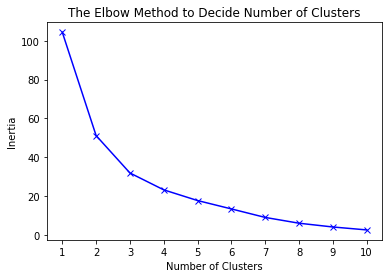

In [4]:
# Finding the best number of cluster for dissect profiles

# Imports
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Remove models that doesn't have performance data (Custom SwAVs) or have a very weak dissect profile (SimCLR+Random)
remove = ["SimCLRV1(R)", "SimCLRV2(R)", "Random(R)", "SwAV200(R)", "SwAV400(R)", "SwAV200bs256(R)", "SwAV400_2x244(R)"]
f_s_data = norm_semantic_data[~norm_semantic_data.index.isin(remove)].iloc[:,1:]
inertias = []

assignments = []
K = range(1,11)

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(f_s_data)
    if k==3:
      assignments = kmeanModel.labels_
    inertias.append(kmeanModel.inertia_)

plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method to Decide Number of Clusters')
plt.xticks(K, K)
plt.show()

# Embedding Visualizations

In [ ]:
# Apply PCA to embed the models into a low dimensional space based on found concepts in eahc model

# Imports
from sklearn.decomposition import PCA

# Remove models that doesn't have performance data (Custom SwAVs) or have a very weak dissect profile (SimCLR+Random)
remove = ["SimCLRV1(R)", "SimCLRV2(R)", "Random(R)", "SwAV200(R)", "SwAV400(R)", "SwAV200bs256(R)", "SwAV400_2x244(R)"]
f_s_data = norm_semantic_data[~norm_semantic_data.index.isin(remove)].iloc[:,1:]

pca = PCA(n_components=3)
components = pca.fit_transform(f_s_data)
pca1 = [ v for (v, _, _) in components]
pca2 = [ v for (_, v, _) in components]
pca3 = [ v for (_, _, v) in components]
components = pd.DataFrame(components, columns=["pca1", "pca2", "pca3"])
components["model"] = [l for l in f_s_data.index ]

In [5]:
# Plot Learned Concepts Embedding (LCE)

# Imports
import plotly.express as px

fig = px.scatter_3d(components, x='pca1', y='pca2', z='pca3', color="model")
fig.show()

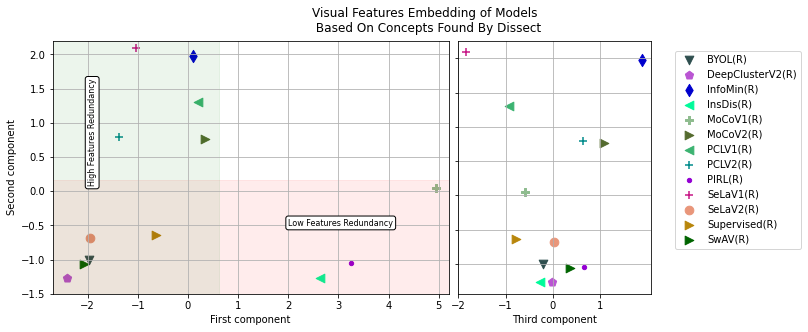

In [7]:
# Plot Learned Concepts Embedding (LCE)

# Imports 
from matplotlib.gridspec import GridSpec

# Pre-define some plotting paramaeters

plt.rcParams["axes.grid"] = True
markers = ['v', 'p', 'd', '<', 'P', '>', '<', '+', '.', '+', 'o', '>', '>', 'p', '>', 'v', '^', 'v', '*', 'D']
colors = ['darkslategrey', 'mediumorchid', 'mediumblue', 'mediumspringgreen',
       'darkseagreen', 'darkolivegreen', 'mediumseagreen', 'darkcyan',
       'darkviolet', 'mediumvioletred', 'darksalmon', 'darkgoldenrod',
       'darkgreen', 'darkgrey', 'mediumaquamarine', 'darkblue',
       'darkslateblue', 'darkorange', 'darkgray', 'darkorchid']

fig = plt.figure(figsize=(9, 4))
gs = GridSpec(1,3, fig)

# Plot first and second componenets scatter plot
ax1 = fig.add_subplot(gs[0,:2])
ax1.set_ylabel("Second component")
ax1.set_xlabel("First component")
for x, y, l, marker, color in zip(pca1, pca2, [l for l in f_s_data.index ], markers, colors):
  ax1.scatter(x, y, label=l, marker=marker, color=color, s=75)
ax1.axvspan(-3, 6,  alpha=0.075, color="red", ymin=-1, ymax=0.45)
ax1.axhspan(-2, 3,  alpha=0.075, color="green", xmin=-1, xmax=0.42)
ax1.annotate( "Low Features Redundancy", (1, -0.6), xytext=(2, -0.5), bbox={"boxstyle":"round", "fc":"1"}, size=8,)
ax1.annotate( "High Features Redundancy",  (1, -0.6), xytext=(-2, 0.1), bbox={"boxstyle":"round", "fc":"1"}, size=8, rotation=90)
ax1.set_xlim((-2.7, 5.2))
ax1.set_ylim((-1.5, 2.2))

# Plot third component scatter plot
ax2 =  fig.add_subplot(gs[0,2])
ax2.set_xlabel("Third component")
for x, y, l, marker, color in zip(pca3, pca2, [l for l in f_s_data.index], markers, colors):
  ax2.scatter(x, y, label=l, marker=marker, color=color, s=75)
ax2.set_yticklabels([])
ax2.set_xticks(range(-2, 2, 1))

fig.tight_layout(pad=0.2)
plt.legend(loc="upper right", bbox_to_anchor=(1.8, 0.98))
plt.suptitle("Visual Features Embedding of Models \n Based On Concepts Found By Dissect", position=(0.65,1.11))
plt.show()

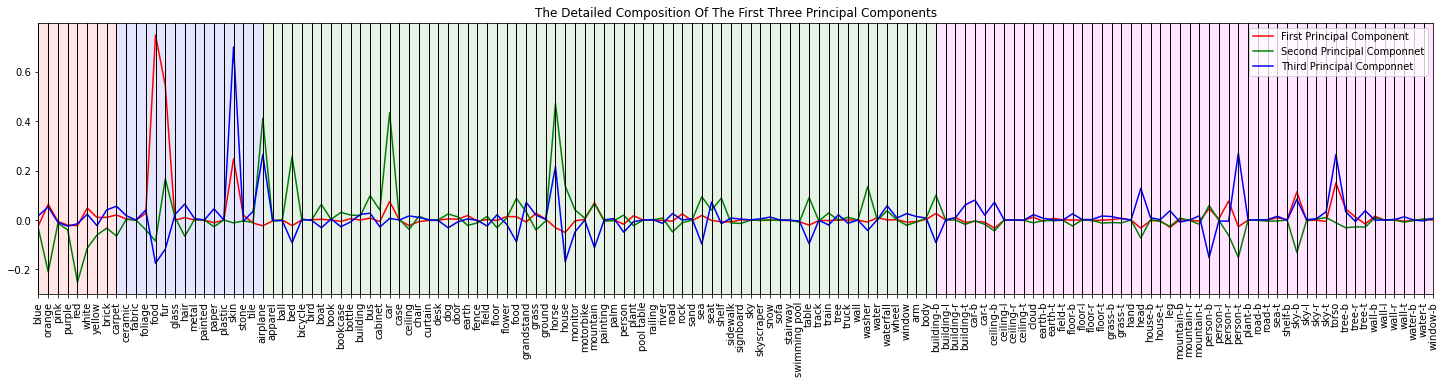

In [9]:
# Plot Learned Concepts Embedding (LCE) PCA Components

# Imports 
from pandas.plotting import parallel_coordinates

# Componenets Coefficients as Dataframe
comps = pd.DataFrame([pca.components_[0], pca.components_[1], pca.components_[2]],
                     columns= [c.replace("o_","").replace("c_","").replace("m_","").replace("p_","") for c in f_s_data.columns])
comps["class"] = ["First Principal Component", "Second Principal Componnet", "Third Principal Componnet"]

# Make the plot 
plt.figure(figsize=(25,5))
parallel_coordinates(comps, class_column="class", color=["red", "green", "blue"])
plt.xticks(rotation=90)
# Add shades
plt.axvspan(0, 8, alpha=0.1, color="red")
plt.axvspan(8, 23,  alpha=0.1, color="blue" )
plt.axvspan(23, 92, alpha=0.1, color="green")
plt.axvspan(92, 144, alpha=0.1, color="magenta")

plt.title("The Detailed Composition Of The First Three Principal Components")
plt.show()

In [ ]:
components_perf = components.merge(data[["model", "dt_ImageNet"]], on="model")
components_perf = components_perf[components_perf["model"]!="SeLaV1(R)"]

from sklearn.neighbors import KNeighborsRegressor
clf = KNeighborsRegressor(5, weights='distance')
clf.fit(components_perf[["pca1", "pca2"]].values, components_perf["dt_ImageNet"].values)

x= np.arange(-3, 6, 0.2)
y=  np.arange(-3, 6, 0.2)
X, Y = np.meshgrid(x, y)
Z = clf.predict( np.stack([X.flatten(), Y.flatten()], axis=1) )
Z = Z.reshape(len(x), len(y))
plt.contourf(x, y, Z,  cmap="Reds")
plt.colorbar()

for x, y, l, marker, color in zip(pca1, pca2, [l for l in components_perf["model"] ], markers, colors):
  plt.scatter(x, y, label=l, marker=marker, color=color)

plt.legend(loc="upper right", bbox_to_anchor=(1.8,1.02))
plt.title("Semantic Space of models based on concepts found by Dissect ")
plt.xlabel("pca.1")
plt.ylabel("pca.2")
plt.xlim((-3,5.5))
plt.ylim((-1.3,2.8))

plt.show()